In [1]:
use_plaidml = False

if use_plaidml:
    raise Exception("PlaidML implementation broken")
    import plaidml.keras
    plaidml.keras.install_backend()
    import keras
    import keras.backend as K
else:
    import tensorflow as tf
    import tensorflow.keras as keras
    import tensorflow.keras.backend as K
print(keras.backend.__name__, keras.__version__)

tensorflow.keras.backend 2.2.4-tf


# Pathfinder

In [ ]:
from hGRU import hGRUCell, hGRUConv_binary

In [ ]:
x = K.random_normal((32,128,128,1))
y = K.random_normal((32,2))

In [ ]:
import numpy as np
model = hGRUConv_binary(conv1_init = np.load("gabor_serre.npy").transpose([2,3,1,0]))
model.build(x.shape)
model.compile(optimizer='rmsprop', loss=['mean_squared_error'])
model.fit(x=x,y=y, epochs=10)
model.predict(x)

In [ ]:
model.summary()

# BSDS500

In [1]:
from data_generator import data_generator_BSDS
gen = data_generator_BSDS("BSR/BSDS500/data/images/train/","BSR/BSDS500/data/groundTruth/train/")

In [2]:
from hGRU import hGRUConv_segment
model = hGRUConv_segment()
model.compile(optimizer='adam', loss=['binary_crossentropy'])
model.fit_generator(gen, epochs=1, steps_per_epoch=20)

hGRU using Keras backend: tensorflow.keras.backend
20/20 [==============================] - 364s 18s/step - loss: 0.2429


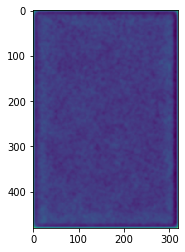

In [6]:
x,y = next(gen)
import matplotlib.pyplot as plt
plt.imshow(model.predict(x)[0].squeeze())
plt.show()